# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso.  
Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd

# TODO: Agregar las librerías que hagan falta

from sklearn.linear_model import SGDClassifier, LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score,
                             classification_report, confusion_matrix,
                             roc_curve, auc,
                             average_precision_score, precision_recall_curve)
from ml.visualization import plot_confusion_matrix, classifier_boundary, plot_learning_curve

from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

np.random.seed(0)  # Para mayor determinismo

* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
* http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

---
## Carga de datos

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")

display(dataset.head())

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


Atributos:

* **TARGET** = Label: 1 = client defaulted on loan - 0 = loan repaid
* **LOAN** = Amount of the loan request
* **MORTDUE** = Amount due on existing mortgage
* **VALUE** = Value of current property
* **YOJ** = Years at present job
* **DEROG** = Number of major derogatory reports
* **DELINQ** = Number of delinquent credit lines
* **CLAGE** = Age of oldest trade line in months
* **NINQ** = Number of recent credit lines
* **CLNO** = Number of credit lines
* **DEBTINC** = Debt-to-income ratio

**NOTA:** TARGET es lo que hay que predecir

In [3]:
# 11 columnas: 10 features + 1 clase
print("Shape dataset =", dataset.shape)

Shape dataset = (1854, 11)


In [4]:
# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

In [5]:
print("Counter TARGET =", Counter(y))

Counter TARGET = Counter({0: 1545, 1: 309})


---
## Ejercicio 1: División de datos en conjuntos de entrenamiento y evaluación

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (o *training*) y evaluación (o *test*).

El primero será utilizado para la creación/selección del modelo de clasificación. El segundo se utilizará sólo al final (una vez elegidos los mejores hiperparámetros) para ver cuál es el resultado final del modelo sobre un conjunto de datos independiente.

Links:
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [6]:
# TODO: Dividir en datos de entrenamiento y evaluación

# Dividimos: Train 80% y Test 20%
# Datos divididos de forma estratificada (stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
print("Shape X_train =", X_train.shape)
print("")
print("Shape X_test =", X_test.shape)

Shape X_train = (1483, 10)

Shape X_test = (371, 10)


In [8]:
print("Counter y_train =", Counter(y_train))
print("")
print("Counter y_test =", Counter(y_test))

Counter y_train = Counter({0: 1232, 1: 251})

Counter y_test = Counter({0: 313, 1: 58})


In [9]:
display(X_train.head(10))
print("=====")
display(y_train.head(10))

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1240,9400,92340.0,125451.0,7.0,0.0,0.0,129.113725,1.0,22.0,36.349975
1183,14800,43983.0,60826.0,4.0,1.0,1.0,113.897967,1.0,9.0,27.108082
692,20100,59726.0,79982.0,8.0,1.0,0.0,74.210759,2.0,28.0,36.846922
871,25200,73168.0,93608.0,9.0,0.0,0.0,151.121480,0.0,21.0,35.590327
1353,17000,70039.0,100993.0,7.0,0.0,0.0,261.911317,1.0,11.0,36.564330
1089,16000,71861.0,95315.0,24.0,0.0,0.0,241.412515,1.0,23.0,35.474773
1305,10600,62909.0,81411.0,15.0,0.0,0.0,238.314471,1.0,35.0,34.680382
1364,49900,45455.0,102971.0,9.0,0.0,0.0,197.963309,2.0,36.0,42.064279
1287,18600,84874.0,115759.0,9.0,0.0,0.0,146.069811,3.0,18.0,39.834320
302,10400,63626.0,79477.0,12.0,0.0,0.0,260.797262,0.0,27.0,27.942866


=====


1240    0
1183    0
692     0
871     0
1353    0
1089    0
1305    0
1364    0
1287    0
302     0
Name: TARGET, dtype: int64

---
## Ejercicio 2: Elección de un modelo

Basándose en lo visto en el teórico escojan y justifiquen un modelo de aprendizaje automático. Recuerden que los pasos para elegir un modelo son:

### 2.1. Selección de hipótesis

Estamos tratando un problema de clasificacion binaria:
* 0 = Loan repaid
* 1 = Client defaulted on loan

Vamos a usar un modelo lineal con descenso de gradiente.

### 2.2. Selección de regularizador

Penalizar valores grandes de los coeficientes (penalty).

Usaremos el factor de regularizacion L2.

### 2.3. Selección de función de coste

Como funcion de coste (loss function) usaremos: Quadratic Loss (squared_loss)

### 2.4. Justificación de las selecciones

*TODO*

---
## Ejercicio 3: Selección de hiperparámetros

Utilizando búsqueda exhaustiva (*grid search*) con *5-fold cross-validation* y utilizando como métrica el área bajo la curva de ROC (o *ROC-AUC*), hagan una selección de los mejores hiperparámetros para su conjunto de datos y el modelo que hayan elegido en el apartado anterior.

Links:
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [11]:
# TODO: Selección de hiperparámetros

#loss = 'hinge'  # Funcion de Coste (Apto para SVM)
#loss = 'log'  # Funcion de Coste
#loss = 'squared_hinge'  # Funcion de Coste (Apto para SVM)
#loss = 'perceptron'  # Funcion de Coste
loss = 'squared_loss'  # Funcion de Coste

penalty = 'l2'  # Regularizador
cv = 5  # Cross-validation
scoring = 'roc_auc'  # Metrica a usar: Area bajo la curva ROC (ROC-AUC)

exploring_params = {
    'learning_rate': ['constant'],
    'eta0': [0.1, 0.05, 0.01, 0.005, 0.001],  # Tasa de entrenamiento
    'alpha': [0.1, 0.05, 0.01, 0.005, 0.001]  # Tasa de regularización
}
sgd_class = SGDClassifier(loss=loss, penalty=penalty, tol=1e-3)
#sgd_class = SGDRegressor(loss=loss, penalty=penalty, tol=1e-3)
#sgd_class = LinearSVC(loss=loss, penalty=penalty, tol=1e-3)
model = GridSearchCV(sgd_class, exploring_params, cv=cv, scoring=scoring)
#model.fit(X_train, y_train)

y_score = model.fit(X_train, y_train).decision_function(X_test)

print("Exploración de hiperparámetros para función de coste \"%s\"" % loss)
print("====================================================")

print("\tPuntajes de la grilla:")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("\tROC AUC: %0.3f (+/- %0.03f) para los parámetros %r" % (mean, std ** 2, params))

print("\tMejor conjunto de parámetros:")
print("\t\t{}".format(model.best_params_))

Exploración de hiperparámetros para función de coste "squared_loss"
	Puntajes de la grilla:
	ROC AUC: 0.480 (+/- 0.003) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant'}
	ROC AUC: 0.459 (+/- 0.001) para los parámetros {'alpha': 0.1, 'eta0': 0.05, 'learning_rate': 'constant'}
	ROC AUC: 0.512 (+/- 0.004) para los parámetros {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant'}
	ROC AUC: 0.509 (+/- 0.002) para los parámetros {'alpha': 0.1, 'eta0': 0.005, 'learning_rate': 'constant'}
	ROC AUC: 0.456 (+/- 0.001) para los parámetros {'alpha': 0.1, 'eta0': 0.001, 'learning_rate': 'constant'}
	ROC AUC: 0.552 (+/- 0.002) para los parámetros {'alpha': 0.05, 'eta0': 0.1, 'learning_rate': 'constant'}
	ROC AUC: 0.520 (+/- 0.004) para los parámetros {'alpha': 0.05, 'eta0': 0.05, 'learning_rate': 'constant'}
	ROC AUC: 0.480 (+/- 0.003) para los parámetros {'alpha': 0.05, 'eta0': 0.01, 'learning_rate': 'constant'}
	ROC AUC: 0.468 (+/- 0.003) para los parámetros {'alpha':

---
## Ejercicio 4: Métricas sobre el conjunto de evaluación

Una vez encontrados los mejores hiperparámetros para el modelo seleccionado en los apartados anteriores se evalúa el modelo final entrenado sobre el conjunto de datos de evaluación seleccionado en el ejercicio 1.  
Pueden utilizar las métricas que crean convenientes. Es mejor utilizar más de una métrica.  
Particularmente el *reporte de clasificación* y la *matriz de confusión* son buenos ejemplos de métricas.

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):
-----------------------------------------------------------------------------------

             precision    recall  f1-score   support

          0       0.84      0.87      0.86       313
          1       0.15      0.12      0.13        58

avg / total       0.73      0.75      0.74       371


Metricas a usar:
----------------
	* Accuracy  = 0.75
	* F1        = 0.13
	* Precision = 0.15
	* Recall    = 0.12




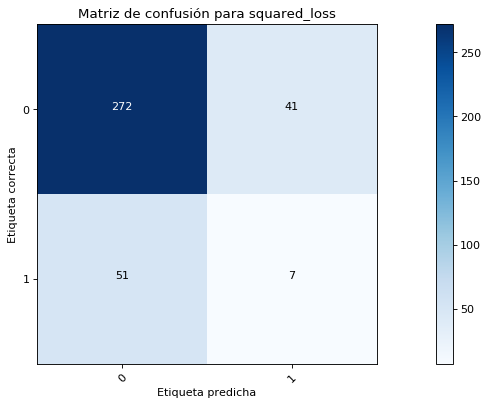

In [30]:
# TODO: Evaluación del modelo
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):")
print("-----------------------------------------------------------------------------------", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
print("\nMetricas a usar:")
print("----------------")
print("\t* Accuracy  = {:.2f}".format(acc))
print("\t* F1        = {:.2f}".format(f1))
print("\t* Precision = {:.2f}".format(prec))
print("\t* Recall    = {:.2f}".format(rec))
print("")
print("================================================", end="\n\n")

plt.subplot(1, 1, 1)
plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=[0, 1],
                      title="Matriz de confusión para %s" % loss)

---
## Ejercicio 5 (opcional): Curvas de ROC

Como ejercicio adicional (opcional), pueden redefinir el umbral de decisión óptimo del problema a partir de los resultados que muestren curvas de ROC como justificación. 

Pueden ver esto mediante la [graficación de las curvas de ROC](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). En el link que se les brinda se muestra como hacer para graficar curvas de ROC para problemas multiclase. Sin embargo se puede adaptar fácilmente a un problema binario obviando la parte donde se calcula la curva clase por clase.

### 5.1. ROC Curve

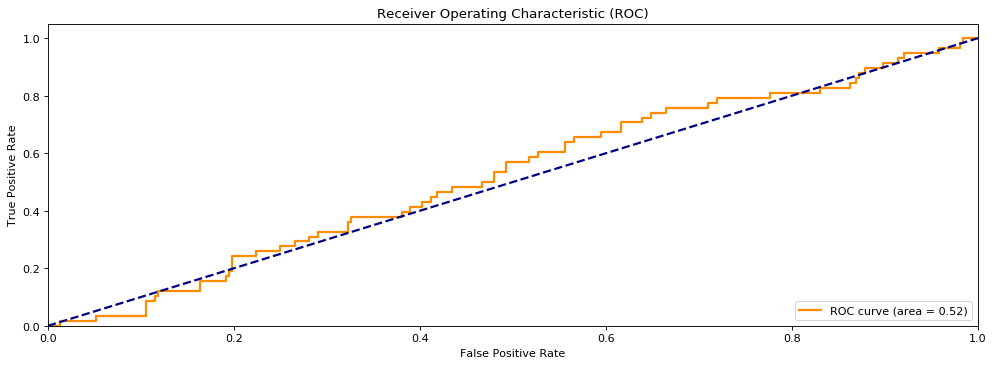

In [33]:
# TODO: Redefinir umbral de clasificación a través de los resultados vistos por graficar curvas de ROC
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### 5.2. Precision-Recall Curve

Average precision-recall score: 0.16


Text(0.5,1,'2-class Precision-Recall curve: AP=0.16')

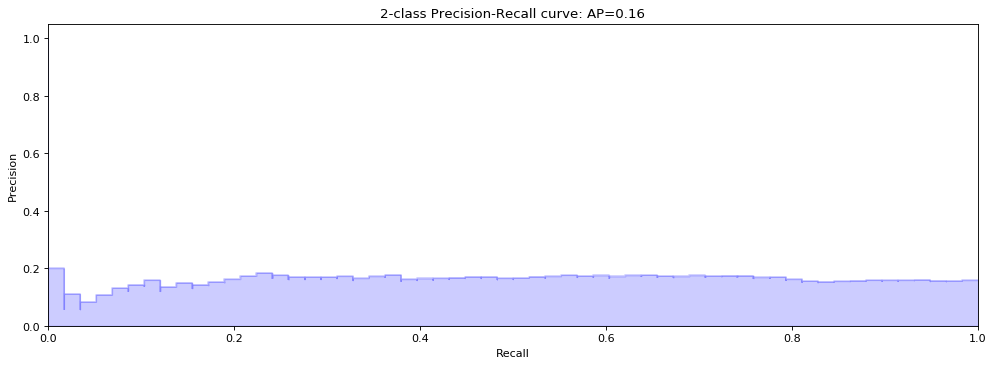

In [34]:
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

---
### <<<<< Usando otras formas >>>>>

In [35]:
# TARGET - LOAN - MORTDUE - VALUE - YOJ - DEROG - DELINQ - CLAGE - NINQ - CLNO - DEBTINC

# Seleccionamos dos atributos de los listados en el apartado anterior, uno para el eje x y otro para el eje y
X_train_feature = X_train[['LOAN', 'MORTDUE']]
X_test_feature = X_test[['LOAN', 'MORTDUE']]

Accuracy Train: 0.17
Accuracy Test: 0.16



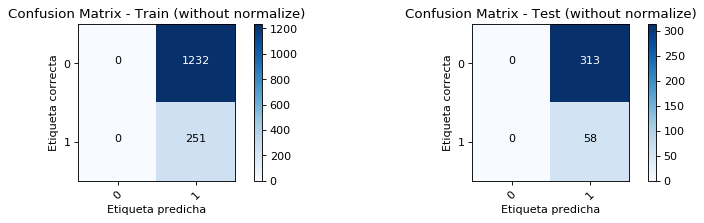

In [36]:
# ------------------------- Perceptron ------------------------- #

penalty = 'l1' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados), elasticnet (l1 + l2).
alpha = 100 # Parámetro de regularización. También denominado como parámetro `lambda`.
max_iter = 10000 # antidad máxima de iteraciones del algoritmo
# NOTA: the iterations will stop when: (loss > previous_loss - tol)
tol = 0.1 # Precisión del algoritmo (error mínimo entre una iteración y la siguiente)
eta = 1 # Parámetro de actualización de los pesos. También denominado como parámetro `alpha`.

model = Perceptron(penalty=penalty, alpha=alpha, max_iter=max_iter, tol=tol, eta0=eta)
model.fit(X_train_feature, y_train)

# Evaluamos el desempeño del clasificador utilizando la exactitud (accuracy) sobre el conjunto
# de datos de entrenamiento (X_train, y_train) y lo comparamos con el de validación (X_val, y_val)
# La exactitud toma valor en el rango [0, 1] donde más alto es mejor
print('Accuracy Train: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Accuracy Test: %.2f' % accuracy_score(y_test, model.predict(X_test_feature)))
print("")

plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=['0', '1'],
                      title='Confusion Matrix - Train (without normalize)')
plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_test, model.predict(X_test_feature)),
                      classes=['0', '1'],
                      title='Confusion Matrix - Test (without normalize)')

plt.show()

In [37]:
# TESTEANDO

# ------------------------- Perceptron ------------------------- #

penalty = 'l1' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados), elasticnet (l1 + l2).
alpha = 100 # Parámetro de regularización. También denominado como parámetro `lambda`.
max_iter = 10000 # antidad máxima de iteraciones del algoritmo
# NOTA: the iterations will stop when: (loss > previous_loss - tol)
tol = 0.1 # Precisión del algoritmo (error mínimo entre una iteración y la siguiente)
eta = 1 # Parámetro de actualización de los pesos. También denominado como parámetro `alpha`.

ptron = Perceptron(penalty=penalty, max_iter=max_iter, tol=tol)


cv = 5  # Cross-validation
scoring = 'roc_auc'  # Metrica a usar: Area bajo la curva ROC (ROC-AUC)

exploring_params = {
    'eta0': [1, 0.5, 0.1, 0.01, 0.005, 0.001],  # Tasa de entrenamiento
    'alpha': [100, 50, 10, 1, 0.1, 0.01, 0.005, 0.001]  # Tasa de regularización
}

model = GridSearchCV(ptron, exploring_params, cv=cv, scoring=scoring)
#model.fit(X_train_feature, y_train)

y_score = model.fit(X_train_feature, y_train).decision_function(X_test_feature)

#print("Exploración de hiperparámetros para función de coste \"%s\"" % loss)
#print("====================================================")

print("\tPuntajes de la grilla:")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("\t\tExactitud: %0.3f (+/- %0.03f) para los parámetros %r" % (mean, std ** 2, params))

print("\tMejor conjunto de parámetros:")
print("\t\t{}".format(model.best_params_))

# Evaluamos el desempeño del clasificador utilizando la exactitud (accuracy) sobre el conjunto
# de datos de entrenamiento (X_train, y_train) y lo comparamos con el de validación (X_val, y_val)
# La exactitud toma valor en el rango [0, 1] donde más alto es mejor
print('Accuracy Train: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Accuracy Test: %.2f' % accuracy_score(y_test, model.predict(X_test_feature)))

	Puntajes de la grilla:
		Exactitud: 0.539 (+/- 0.002) para los parámetros {'alpha': 100, 'eta0': 1}
		Exactitud: 0.539 (+/- 0.002) para los parámetros {'alpha': 100, 'eta0': 0.5}
		Exactitud: 0.510 (+/- 0.000) para los parámetros {'alpha': 100, 'eta0': 0.1}
		Exactitud: 0.520 (+/- 0.001) para los parámetros {'alpha': 100, 'eta0': 0.01}
		Exactitud: 0.520 (+/- 0.001) para los parámetros {'alpha': 100, 'eta0': 0.005}
		Exactitud: 0.539 (+/- 0.002) para los parámetros {'alpha': 100, 'eta0': 0.001}
		Exactitud: 0.553 (+/- 0.002) para los parámetros {'alpha': 50, 'eta0': 1}
		Exactitud: 0.553 (+/- 0.002) para los parámetros {'alpha': 50, 'eta0': 0.5}
		Exactitud: 0.535 (+/- 0.002) para los parámetros {'alpha': 50, 'eta0': 0.1}
		Exactitud: 0.549 (+/- 0.002) para los parámetros {'alpha': 50, 'eta0': 0.01}
		Exactitud: 0.549 (+/- 0.002) para los parámetros {'alpha': 50, 'eta0': 0.005}
		Exactitud: 0.553 (+/- 0.002) para los parámetros {'alpha': 50, 'eta0': 0.001}
		Exactitud: 0.536 (+/- 0.00

Accuracy Train: 0.83
Accuracy Test: 0.84



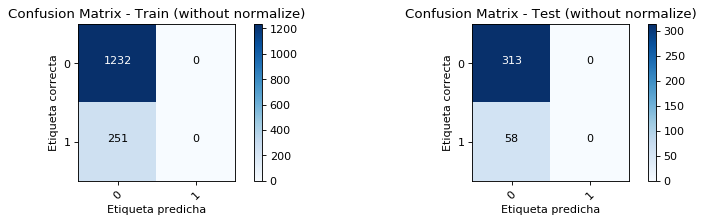

In [15]:
# ------------------------- Regresión logística con atributos regulares ------------------------- #

penalty = 'l1' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados).
alpha = 1 # Parámetro de regularización. También denominado como parámetro `lambda`. Debe ser mayor que 0.
max_iter = 10000 # Cantidad máxima de iteraciones del algoritmo.
tol = 0.1 # Precisión del algoritmo (error mínimo entre una iteración y la siguiente).

model = LogisticRegression(penalty=penalty, C=1./alpha, max_iter=max_iter, tol=tol)
model.fit(X_train_feature, y_train)

print('Accuracy Train: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Accuracy Test: %.2f' % accuracy_score(y_test, model.predict(X_test_feature)))
print("")

plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=['0', '1'],
                      title='Confusion Matrix - Train (without normalize)')
plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_test, model.predict(X_test_feature)),
                      classes=['0', '1'],
                      title='Confusion Matrix - Test (without normalize)')

plt.show()

Accuracy Train: 0.83
Accuracy Test: 0.84



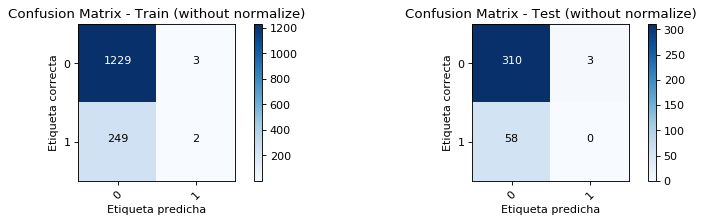

In [16]:
# ------------------------- Regresión logística con atributos polinomiales ------------------------- #

polynomial_degree = 2 # Grado del polinomio.
poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_feature)
X_poly_train = poly_features.transform(X_train_feature)
X_poly_test = poly_features.transform(X_test_feature)

penalty = 'l1' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados).
alpha = 1 # Parámetro de regularización. También denominado como parámetro `lambda`. Debe ser mayor que 0.
max_iter = 10000 # Cantidad máxima de iteraciones del algoritmo.
tol = 0.01 # Precisión del algoritmo (error mínimo entre una iteración y la siguiente).

model = LogisticRegression(penalty=penalty, C=1./alpha, max_iter=max_iter, tol=tol)
model.fit(X_poly_train, y_train)

print('Accuracy Train: %.2f' %  accuracy_score(y_train, model.predict(X_poly_train)))
print('Accuracy Test: %.2f' % accuracy_score(y_test, model.predict(X_poly_test)))
print("")

plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_poly_train)),
                      classes=['0', '1'],
                      title='Confusion Matrix - Train (without normalize)')
plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_test, model.predict(X_poly_test)),
                      classes=['0', '1'],
                      title='Confusion Matrix - Test (without normalize)')

plt.show()